# PolygonRNN++ Demo
This demo will illustrates step by step how to run PolygonRNN++ on a sample image crop.

In [1]:
# Imports
import os
import tensorflow as tf
import numpy as np
from skimage import io, transform
import utils
from poly_utils import vis_polys
from PolygonModel import PolygonModel
from EvalNet import EvalNet
from GGNNPolyModel import GGNNPolygonModel

In [2]:
# External PATHS
work_path = '/home/jovyan/work/'
imgs_path = work_path + 'imgs/'
models_path = work_path + 'models/'
PolyRNN_metagraph = models_path + 'poly/polygonplusplus.ckpt.meta'
PolyRNN_checkpoint = models_path + 'poly/polygonplusplus.ckpt'
EvalNet_checkpoint = models_path + 'evalnet/evalnet.ckpt'
GGNN_metagraph = models_path + 'ggnn/ggnn.ckpt.meta'
GGNN_checkpoint = models_path + 'ggnn/ggnn.ckpt'

# Constants
_BATCH_SIZE = 1
_FIRST_TOP_K = 6

In [3]:
# Creating the graphs
evalGraph = tf.Graph()
polyGraph = tf.Graph()
ggnnGraph = tf.Graph()

In [4]:
%%time

# Initializing and restoring the evaluator net.
with evalGraph.as_default():
    with tf.variable_scope("discriminator_network"):
        evaluator = EvalNet(_BATCH_SIZE)
        evaluator.build_graph()
    saver = tf.train.Saver()

    # Start session
    evalSess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True
    ), graph=evalGraph)
    saver.restore(evalSess, EvalNet_checkpoint)

INFO:tensorflow:Restoring parameters from /home/jovyan/work/models/evalnet/evalnet.ckpt
CPU times: user 628 ms, sys: 244 ms, total: 872 ms
Wall time: 865 ms


In [5]:
%%time

# Initializing and restoring PolyRNN++
model = PolygonModel(PolyRNN_metagraph, polyGraph)
model.register_eval_fn(lambda input_: evaluator.do_test(evalSess, input_))
polySess = tf.Session(config=tf.ConfigProto(
    allow_soft_placement=True
), graph=polyGraph)
model.saver.restore(polySess, PolyRNN_checkpoint)

INFO:tensorflow:Restoring parameters from /home/jovyan/work/models/poly/polygonplusplus.ckpt
CPU times: user 33.9 s, sys: 1.7 s, total: 35.6 s
Wall time: 34.4 s


In [6]:
%%time

# Initializing and restoring GGNN
ggnnGraph = tf.Graph()
ggnnModel = GGNNPolygonModel(GGNN_metagraph, ggnnGraph)
ggnnSess = tf.Session(config=tf.ConfigProto(
    allow_soft_placement=True
), graph=ggnnGraph)

ggnnModel.saver.restore(ggnnSess,GGNN_checkpoint)

INFO:tensorflow:Restoring parameters from /home/jovyan/work/models/ggnn/ggnn.ckpt
CPU times: user 5.3 s, sys: 380 ms, total: 5.68 s
Wall time: 5.41 s


In [7]:
# List images
img_names = os.listdir(imgs_path)
img_names = [img_name for img_name in img_names if os.path.isfile(os.path.join(imgs_path, img_name))]
img_names = sorted(img_names)
for index, img_name in enumerate(img_names):
    print index, img_name

0 frankfurt_000000_000294_42.png
1 frankfurt_000000_000576_21.png
2 frankfurt_000000_000576_46.png
3 frankfurt_000000_001016_20.png
4 medical_00_5_11.png
5 medical_00_5_20.png


In [8]:
# INPUT IMG CROP (224x224x3) -> object should be centered
img_name = img_names[3]
crop_path = imgs_path + img_name
print crop_path

/home/jovyan/work/imgs/frankfurt_000000_001016_20.png


In [18]:
%%time

# Testing
image_np = io.imread(crop_path)

image_shape = image_np.shape
if image_shape != (224, 224, 3):
    print image_shape
    image_np = transform.resize(image_np, (224,224), mode='symmetric')

image_np = np.expand_dims(image_np, axis=0)
preds = [model.do_test(polySess, image_np, top_k) for top_k in range(_FIRST_TOP_K)]

# Sort predictions based on the eval score to pick the best.
preds = sorted(preds, key=lambda x: x['scores'][0], reverse=True)

CPU times: user 2.36 s, sys: 256 ms, total: 2.62 s
Wall time: 1.62 s


[None, None, None, None, None, None]

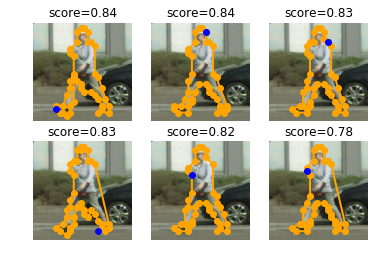

In [19]:
# Visualizing TOP_K and scores
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3)
axes=np.array(axes).flatten()
[vis_polys(axes[i], image_np[0], np.array(pred['polys'][0]), title='score=%.2f' % pred['scores'][0]) for i,pred in enumerate(preds)]

In [20]:
%%time

# Let's run GGNN now on the bestPoly
bestPoly = preds[0]['polys'][0]
feature_indexs, poly, mask = utils.preprocess_ggnn_input(bestPoly)
preds_gnn = ggnnModel.do_test(ggnnSess, image_np, feature_indexs, poly, mask)
refinedPoly=preds_gnn['polys_ggnn']

CPU times: user 160 ms, sys: 32 ms, total: 192 ms
Wall time: 112 ms


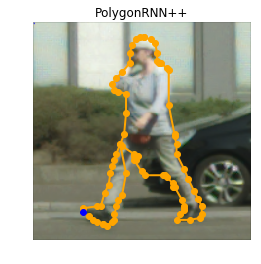

In [21]:
# Visualize the final prediction
fig, ax = plt.subplots(1,1)
vis_polys(ax,image_np[0],refinedPoly[0], title='PolygonRNN++')